In [6]:
#Extraído de https://www.kaggle.com/piantic/train-siim-covid-19-detection-fasterrcnn/notebook, pensado para mejora de procesamiento de datos por modelo.
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

# torch
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
!pip install torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
!pip install numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because nor

In [104]:
def get_train_file_path(image_id):
    return "./train/{}.jpg".format(image_id)

#def get_test_file_path(image_id):
#    return "../input/siim-covid19-resized-to-256px-jpg/test/{}.jpg".format(image_id)

In [105]:
updated_train_labels = pd.read_csv('./updated_train_labels.csv')

updated_train_labels['jpg_path'] = updated_train_labels['id'].apply(get_train_file_path)
train = updated_train_labels.copy()
display(train.head())


,id,dcm_path,xmin,ymin,xmax,ymax,human_label,negative,typical,indeterminate,...,ImageInstanceUID,img_shape,width,height,frac_xmin,frac_xmax,frac_ymin,frac_ymax,integer_label,jpg_path
0,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,2245.91208,591.20528,3340.57370,2352.75472,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.527705,0.784909,0.169497,0.674528,3,./train/000a312787f2.jpg
1,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,789.28836,582.43035,1815.94498,2499.73327,typical,0,1,0,...,000a312787f2,"(3488, 4256)",4256,3488,0.185453,0.426679,0.166981,0.716667,3,./train/000a312787f2.jpg
2,000c3a3f293f,/kaggle/input/siim-covid19-detection/train/ff0...,0.00000,0.00000,1.00000,1.00000,negative,1,0,0,...,000c3a3f293f,"(2320, 2832)",2832,2320,0.000000,0.000353,0.000000,0.000431,2,./train/000c3a3f293f.jpg
3,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,677.42216,197.97662,1545.21983,1197.75876,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.221670,0.505635,0.077821,0.470817,3,./train/0012ff7358bc.jpg
4,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,1792.69064,402.55250,2409.71798,1606.91050,typical,0,1,0,...,0012ff7358bc,"(2544, 3056)",3056,2544,0.586613,0.788520,0.158236,0.631647,3,./train/0012ff7358bc.jpg


In [125]:
class DefaultConfig:
    n_folds: int = 5
    seed: int = 2021
    num_classes: int = 4 # "negative", "typical", "indeterminate", "atypical"
    img_size: int = 256
    fold_num: int = 0
    device: str = 'cpu'#'cuda:0'

In [126]:
device = torch.device(DefaultConfig.device) if torch.cuda.is_available() else torch.device('cpu')

In [127]:
Adam = False
if Adam: 
    Adam_config = {"lr" : 0.001, "betas" : (0.9, 0.999), "eps" : 1e-08}
else:
    SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.001}


In [128]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.manual_seed(seed) #torch.cuda.manual_seed(seed)
    torch.backends.deterministic = True #torch.backends.cudnn.deterministic = True
    torch.backends.benchmark = True #torch.backends.cudnn.benchmark = True
    
seed_everything(DefaultConfig.seed)

In [129]:

df_folds = train.copy()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=DefaultConfig.seed)
for n, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds.integer_label)):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = int(n)
df_folds['fold'] = df_folds['fold'].astype(int)
print(df_folds.groupby(['fold', df_folds.integer_label]).size())

fold  integer_label
0     0                 126
      1                 299
      2                 347
      3                1207
1     0                 126
      1                 299
      2                 347
      3                1207
2     0                 126
      1                 299
      2                 347
      3                1207
3     0                 126
      1                 298
      2                 347
      3                1207
4     0                 125
      1                 299
      2                 348
      3                1206
dtype: int64


In [130]:
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                 val_shift_limit=0.2, p=0.3), 
            A.RandomBrightnessContrast(brightness_limit=0.2,  
                                       contrast_limit=0.2, p=0.3),
        ], p=0.2),
        A.Resize(height=DefaultConfig.img_size, width=DefaultConfig.img_size, p=1.0),
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0),
    ],
    p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=DefaultConfig.img_size, width=DefaultConfig.img_size, p=1.0),
        #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [131]:
class CustomDataset(Dataset):

    def __init__(self, image_ids, df, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.df = df
        self.file_names = df['jpg_path'].values
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        print(self.file_names)
        image = cv2.imread(self.file_names[index], cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['id'] == image_id]       
        boxes = []
        for bbox in records[['frac_xmin', 'frac_ymin', 'frac_xmax', 'frac_ymax']].values:
            bbox = np.clip(bbox, 0, 1.0)
            temp = A.convert_bbox_from_albumentations(bbox, 'pascal_voc', image.shape[0], image.shape[0]) 
            boxes.append(temp)
        '''
        [0: 'atypical', 1: 'indeterminate', 2: 'negative', 3: 'typical']
        '''
        labels = records['integer_label'].values
        return image, boxes, labels

In [132]:
df_folds = df_folds.set_index('id')
def get_train_dataset(fold_number):    
    return CustomDataset(
        image_ids = df_folds[df_folds['fold'] != fold_number].index.values,
        df = train,
        transforms = get_train_transforms()
    )

def get_validation_dataset(fold_number):
    return CustomDataset(
        image_ids = df_folds[df_folds['fold'] == fold_number].index.values,
        df = train,
        transforms = get_valid_transforms()
    )

def get_train_data_loader(train_dataset, batch_size=16):
    return DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4,
        collate_fn = collate_fn
    )

def get_validation_data_loader(valid_dataset, batch_size=16):
    return DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 4,
        collate_fn = collate_fn
    )    

def collate_fn(batch):
    return tuple(zip(*batch))

print(get_train_dataset(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']


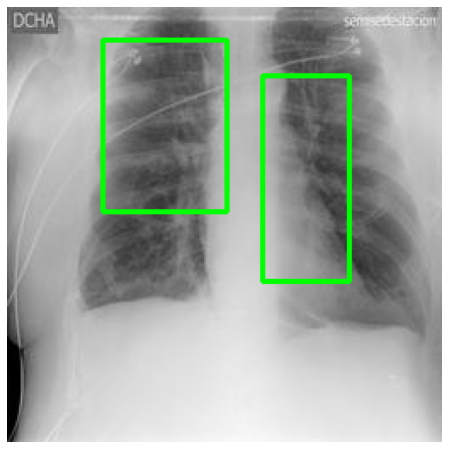

In [133]:
train_dataset = get_train_dataset(0)

image, target, image_id = train_dataset[2]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 255, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [134]:
target

{'boxes': tensor([[ 56.7474,  19.9222, 129.4425, 120.5292],
         [150.1730,  40.5084, 201.8612, 161.7017]], dtype=torch.float64),
 'labels': tensor([3, 3]),
 'image_id': tensor([2])}

['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']
['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']

['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']
['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

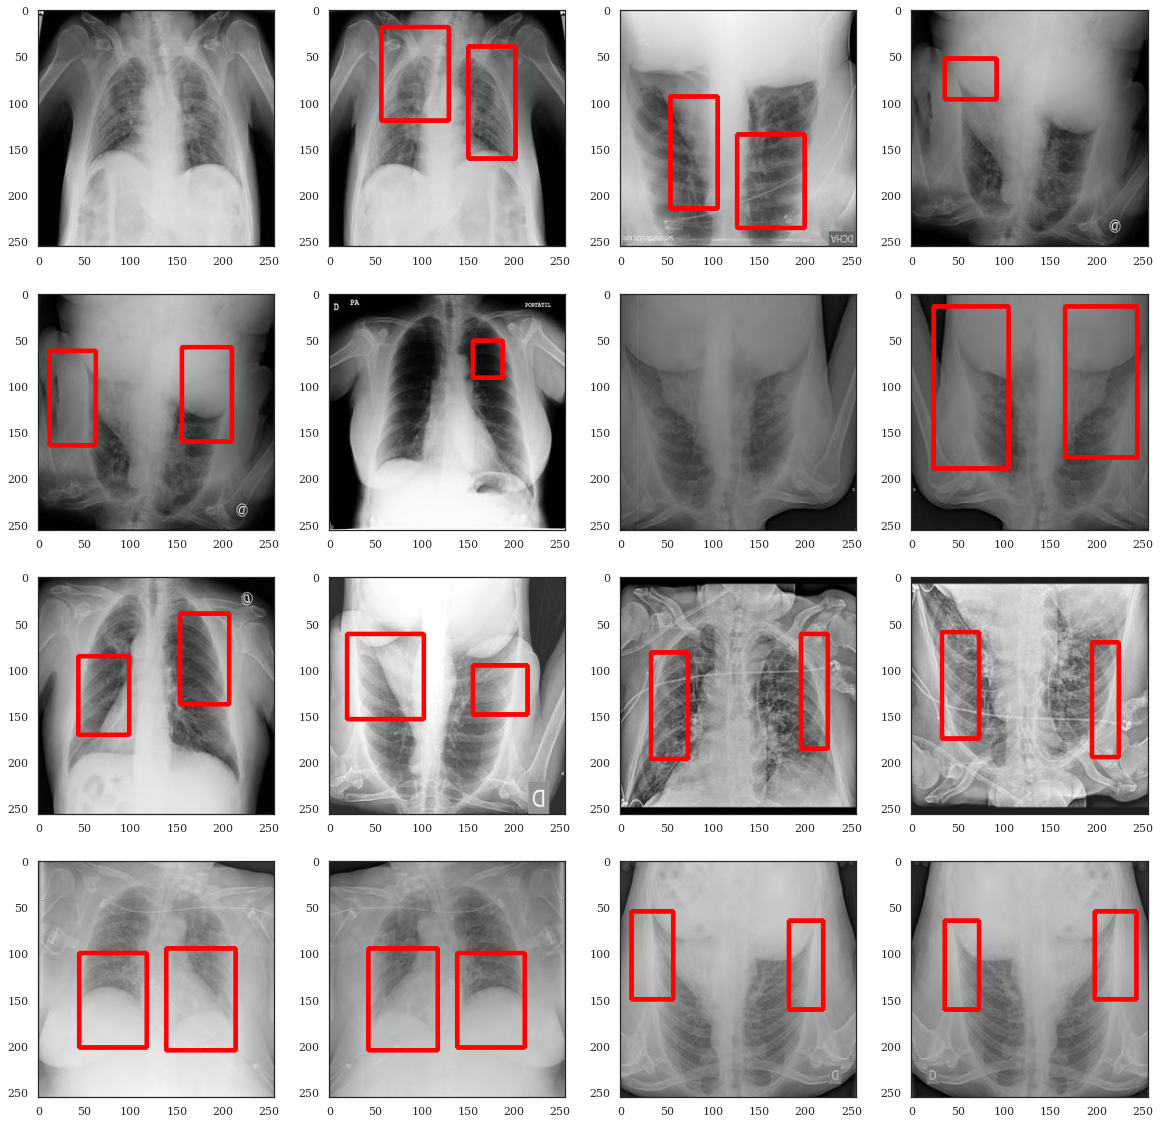

In [135]:
n_rows=4
n_cols=4

# create train dataset and data-loader
train_dataset = get_train_dataset(fold_number=DefaultConfig.fold_num)
train_data_loader = get_train_data_loader(train_dataset, batch_size=16)

images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# plot some augmentations!
fig, ax = plt.subplots(figsize=(20, 20),  nrows=n_rows, ncols=n_cols)
for i in range (n_rows*n_cols):    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255, 0, 0), 3)
    
    ax[i // n_rows][i % n_cols].imshow(sample)   


In [136]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [137]:
iou_thresholds = [0.5]

class EvalMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.image_precision = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, gt_boxes, pred_boxes, n=1):       
        """ pred_boxes : need to be sorted."""
        
        self.image_precision = calculate_image_precision(pred_boxes,
                                                         gt_boxes,
                                                         thresholds=iou_thresholds,
                                                         form='pascal_voc')
        self.count += n
        self.sum += self.image_precision * n
        self.avg = self.sum / self.count


In [138]:
class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.best_score = 0

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        
        # get the configured optimizer
        if Adam:
            self.optimizer = torch.optim.Adam(self.model.parameters(), **Adam_config)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), **SGD_config)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
        self.log(f'Fold num is {DefaultConfig.fold_num}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            
            if e == 0:
                self.best_summary_loss = summary_loss.avg

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            _, eval_scores  = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, image_precision: {eval_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            
            #if summary_loss.avg < self.best_summary_loss:
            if eval_scores.avg > self.best_score:
                self.best_summary_loss = summary_loss.avg
                self.best_score = eval_scores.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=eval_scores.avg)
                #self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        
        # model.eval() mode --> it will return boxes and scores.
        # in this part, just print train_loss
        summary_loss = AverageMeter()
        summary_loss.update(self.best_summary_loss, self.config.batch_size)
        
        eval_scores = EvalMeter()
        validation_image_precisions = []
        
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'val_precision: {eval_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                labels = [target['labels'].float() for target in targets]

                """
                In model.train() mode, model(images)  is returning losses.
                We are using model.eval() mode --> it will return boxes and scores. 
                """
                outputs = self.model(images)               
                
                for i, image in enumerate(images):               
                    gt_boxes = targets[i]['boxes'].data.cpu().numpy()
                    boxes = outputs[i]['boxes'].data.cpu().numpy()
                    scores = outputs[i]['scores'].detach().cpu().numpy()
                    
                    preds_sorted_idx = np.argsort(scores)[::-1]
                    preds_sorted_boxes = boxes[preds_sorted_idx]

                    eval_scores.update(pred_boxes=preds_sorted_boxes, gt_boxes=gt_boxes)

        return summary_loss, eval_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()

        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 

            self.optimizer.zero_grad()
            
            outputs = self.model(images, targets)
            
            loss = sum(loss for loss in outputs.values())
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(), #'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [139]:
class TrainGlobalConfig:
    num_workers: int = 4
    batch_size: int = 16
    n_epochs: int = 2 #40
    lr: float = 0.0002

    img_size = DefaultConfig.img_size
        
    folder = '/kaggle/working/' #folder_name 

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [140]:
class FasterRCNNDetector(torch.nn.Module):
    def __init__(self, pretrained=False, **kwargs):
        super(FasterRCNNDetector, self).__init__()
        # load pre-trained model incl. head
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained, pretrained_backbone=pretrained)
        
        # get number of input features for the classifier custom head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        
        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, DefaultConfig.num_classes)
        
    def forward(self, images, targets=None):
        return self.model(images, targets)

In [141]:
import gc

def get_model(checkpoint_path=None, pretrained=False):
    model = FasterRCNNDetector(pretrained=pretrained)
    
    # Load the trained weights
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        del checkpoint
        gc.collect()
        
    return model #.cuda()

net = get_model(pretrained=True)


In [142]:
def run_training(fold=0):
    net.to(device)
    
    train_dataset = get_train_dataset(fold_number=fold)
    train_data_loader = get_train_data_loader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size
    )
    
    validation_dataset = get_validation_dataset(fold_number=fold)
    validation_data_loader = get_validation_data_loader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_data_loader, validation_data_loader)

In [143]:
validation_dataset = get_validation_dataset(fold_number=DefaultConfig.fold_num)
validation_data_loader = get_validation_data_loader(
    validation_dataset, 
    batch_size=TrainGlobalConfig.batch_size
)

In [144]:
images, targets, image_id = next(iter(validation_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']

['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']

['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/ffe942c8655f.jpg']['./train/000a312787f2.jpg' './train/000a312787f2.jpg'
 './train/000c3a3f293f.jpg' ... './train/ffdc682f7680.jpg'
 './train/ffe942c8655f.jpg' './train/